Vibrating Mesh Nebuliser particle release
====================================================

### Authors: Ciarraí, James, Myriam, Marco

We try to piece-wise fit the following concentration ODE, which assumes homogeneous mixing.


$$
   \dfrac{dC}{dt} = \dfrac{E}{V}-\lambda C
$$

Where $E$ is the generation rate ($mg/m^3$), $V$ is room volume $m^3$ and $\lambda$ is the removal rate $^{-h}$. This then has a general solution:

$$
C(t)=\dfrac{E}{V\lambda}(1-e^{-\lambda t})+ k e^{-\lambda t}
$$

Where $k$ is the integration constant.

The piece-wise fit is done as follows:

 - for 0<$t$<5 minutes: $C=0.003851195$ (this is the average concentration of the first 5 minutes)
 - for 5<$t$<14 minutes: $C = \dfrac{E}{V\lambda }(1-e^{-\lambda t})$
 - for 14<$t$<45 minutes: $C = k e^{-\lambda t}$


We need to estimate $E$, $k$ and $\lambda$

In [1]:
# install if not done yet
#!pip install pyabc --quiet

In [2]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon
from pyabc.visualization import plot_data_callback, plot_kde_2d

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")

Data
----

We use a data set which consists of a vector of time points $t$
and a measurement vector $data$.  


and the measurement data

In [3]:
import pandas as pd
from datetime import datetime
import numpy as np
data = pd.read_csv('../data/vmn_mp_conc.txt', sep='\t',header=0)
data["time"] = data["time"].apply(lambda x: datetime.strptime(x, "%M:%S")) #convert to datetime
data["fraction_of_hour"] = data["time"].apply(lambda x: (x.minute+x.second/60) / 60) #convert to fraction of hour
measurement_data = data['conc_2'] #np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['conc_2']])

as well as the time points at whith to evaluate

In [4]:
measurement_times = data['fraction_of_hour']#np.array(data.loc[list(range(0,44)) + list(range(55, 135)), ['fraction_of_hour']])

Define the analytical model:

 - for 0<$t$<5 minutes: $C=0.003851195$
 - for 5<$t$<14 minutes: $C = \dfrac{E}{V\lambda }(1-e^{-\lambda t})$
 - for 14<$t$<45 minutes: $C = k e^{-\lambda t}$

In [71]:
def model(param):
    """
    Model function for the piecewise solution.
    
    Parameters
    ----------
    param : tuple
        Tuple containing the values of the parameters k and lambda.
    t : array-like
        Array of time values.
        
    Returns
    -------
    C : array-like
        Array of concentration values at the given times.
    """
    E = param['E']
    k = param['k']
    lambda_ = param['lambda_']

    #E, k, lambda_ = param
    t = measurement_times
    # Initialize empty array for concentration values
    C = np.zeros_like(t)
    V = 44.34
    # Loop over time values
    for i, ti in enumerate(t):
        # If time is less than 5 minutes, set concentration to k
        if ti < 5/60:
            C[i] = 0.003851195
        # If time is between 5 and 20 minutes, set concentration according to ODE solution
        elif 5/60 <= ti < 14/60:
            C[i] =  (E/V)*(1-np.exp(-lambda_*(ti-5/60)))/lambda_ + k*np.exp(-lambda_*(ti-5/60)) 
        # If time is greater than 20 minutes, set concentration to 0
        else:
            C[i] = k*np.exp(-lambda_*(ti-14/60)) 
    # Add noise to the simulated data
    sigma = 0.001
    C += np.random.normal(0, sigma, size=C.shape)

    return {"Concentration":C}

#model({"E":0.0001,"k":0.003851195,"lambda_":0.0001})['Concentration'].shape

#distance({"Concentration":measurement_data}, model({"E":10,"k":0.003851195,"lambda_":1.11}))


# An example of the model

Define some example parameters (chosen by eye using a manual piece-wise curve fitting of the VMN_ad_08 file.). For the purpose of this section, I've called them 'true' parameters.

In [68]:
E_true, k_true, lambda_true = np.array([8.38, 0.03, 1.174])
#t1 = measurement_times[15:44]
#t1-np.min(t1)
#model({"E": E_true, "k": k_true, "lambda_":lambda_true})

Solve the model for the true parameter values and visualise the results

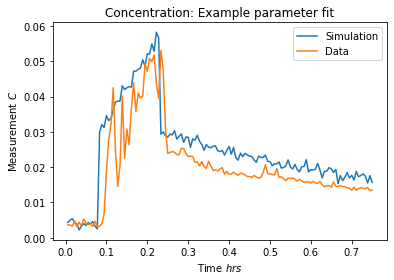

In [69]:
param = {"E": E_true, "k": k_true, "lambda_":lambda_true}
true_trajectory = model(param)["Concentration"]
import matplotlib.pyplot as plt
plt.plot(measurement_times,true_trajectory, color="C0", label='Simulation')
plt.plot(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Time $hrs$')
plt.ylabel('Measurement $C$')
plt.title('Concentration: Example parameter fit')
plt.legend()
plt.show()

#np.array(model({'E':3.851195,'k':0.003,'lambda_':1.174})).max()

##Set up the ABC algorithm

Set up the ABC algorithm - we will use the ABC-SMC algorithm
This runs millions of different combinations of parameters and compares the model output to the data. If the distance between the predicted curves and the observed data is 'small enough', then the parameters are accepted. The distance is calculated using the sum of the squared differences between the model and the data.

In [33]:
def distance(simulation, data):
    return np.absolute(data["Concentration"] - simulation["Concentration"]).sum()

Define the prior distributions for the parameters. We will use uniform priors for all parameters.

In [34]:
parameter_prior = Distribution(
    E=RV("uniform", 0, 10), k=RV("uniform", 0, 5), lambda_=RV("uniform", 0, 5)
)
parameter_prior.get_parameter_names()

['E', 'k', 'lambda_']

This is the function that will be called by the ABC algorithm. It takes a set of parameters and returns the distance between the model and the data.

In [72]:
abc = ABCSMC(
    models=model,
    parameter_priors=parameter_prior,
    distance_function=distance,
    population_size=100,
    transitions=LocalTransition(k_fraction=0.3),
    eps=MedianEpsilon(1000, median_multiplier=0.7),
)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


This tells the abc model where the experimental data is.

In [73]:
abc.new(db_path, {"Concentration": measurement_data});

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/pyabc/storage/dataframe_bytes_storage.py:128: UserWarning: Can't find pyarrow, falling back to less efficient csv to store pandas DataFrames.
Install e.g. via `pip install pyabc[pyarrow]`
  warnings.warn(
ABC.History INFO: Start <ABCSMC id=53, start_time=2022-12-24 21:29:40>


This runs the algorithm

In [74]:
h = abc.run(minimum_epsilon=.5, max_nr_populations=10)

ABC INFO: t: 0, eps: 1.00000000e+03.
ABC INFO: Accepted: 100 / 105 = 9.5238e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.21526330e+02.
ABC INFO: Accepted: 100 / 323 = 3.0960e-01, ESS: 8.0260e+01.
ABC INFO: t: 2, eps: 4.81302407e+01.
ABC INFO: Accepted: 100 / 350 = 2.8571e-01, ESS: 8.4646e+01.
ABC INFO: t: 3, eps: 1.64710764e+01.
ABC INFO: Accepted: 100 / 309 = 3.2362e-01, ESS: 7.7847e+01.
ABC INFO: t: 4, eps: 4.93549941e+00.
ABC INFO: Accepted: 100 / 302 = 3.3113e-01, ESS: 8.6560e+01.
ABC INFO: t: 5, eps: 1.43367643e+00.
ABC INFO: Accepted: 100 / 297 = 3.3670e-01, ESS: 8.5701e+01.
ABC INFO: t: 6, eps: 7.02447306e-01.
ABC INFO: Accepted: 100 / 886 = 1.1287e-01, ESS: 8.2017e+01.
ABC INFO: t: 7, eps: 4.15881385e-01.
ABC INFO: Accepted: 100 / 4277 = 2.3381e-02, ESS: 9.9144e+01.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=53, duration=0:00:21.449695, end_time=2022-12-24 21:30:02>


Visualization of the probability density functions for $E$, $k$ and $\lambda$

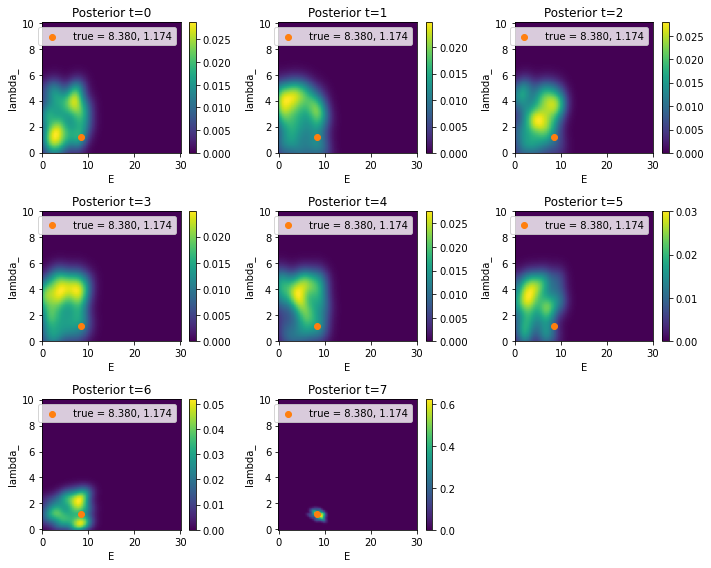

In [75]:
fig = plt.figure(figsize=(10, 8))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(3, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "E",
        "lambda_",
        xmin=0,
        xmax=30,
        numx=200,
        ymin=0,
        ymax=10,
        numy=200,
        ax=ax,
    )
    ax.scatter(
        [E_true],
        [lambda_true],
        color="C1",
        label=r' true = {:.3f}, {:.3f}'.format(
            E_true, lambda_true
        ),
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()
fig.tight_layout()

Plot marginal histograms of the posterior distributions of the three parameters

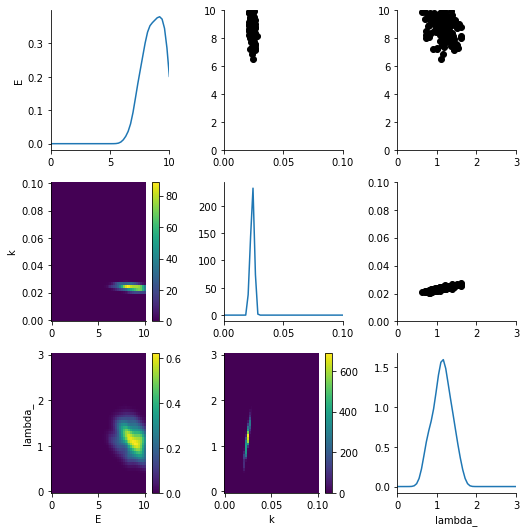

In [76]:
from pyabc.visualization import plot_kde_matrix

limits = dict(E=(0, 10), k=(0, 1E-1), lambda_=(0, 3))
df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

##We plot a 1000 simulated curves using the posterior distributions of the parameters

We can also plot the simulated trajectories:

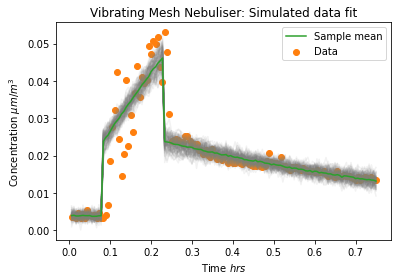

In [77]:
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['Concentration'], color='grey', alpha=0.1)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['Concentration'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

#plt.plot(measurement_times,true_trajectory, color="C0", label='Initial guess')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Time $hrs$')
plt.ylabel('Concentration $\mu m/m^3$')
plt.title('Vibrating Mesh Nebuliser: Simulated data fit')
plt.legend()
plt.show()



Summary table of parameters

In [78]:
# Create a summary table of parameter values
df, w = h.get_distribution(m=0, t=h.max_t)
df['w'] = w
df = df.sort_values('w', ascending=True)
df = df.reset_index(drop=True)
df = df.round(3)
df.head(10)


name,E,k,lambda_,w
0,8.898,0.022,0.767,0.009
1,9.191,0.024,0.947,0.009
2,9.029,0.024,1.094,0.009
3,9.127,0.024,1.069,0.009
4,9.381,0.022,0.704,0.009
5,9.481,0.023,1.021,0.009
6,9.179,0.022,0.994,0.009
7,8.972,0.022,0.964,0.009
8,9.312,0.022,1.019,0.009
9,8.951,0.023,1.090,0.009
